Weights: [-0.9301416329261063, 0.9863245557396509, 0.5869183621197545]

Truth Table for XOR:
 [[1 1 0]
 [1 0 1]
 [0 1 1]
 [0 0 0]]

Took too long.

Learning Rate: 0.24000000000000007
Iterations: 25

New Activation Array: [ 0.76289354  0.32406542  0.18463468 -0.44635703]

Pocket Error: 1
PLA Error w/out Pocket: 2



<Figure size 432x288 with 0 Axes>

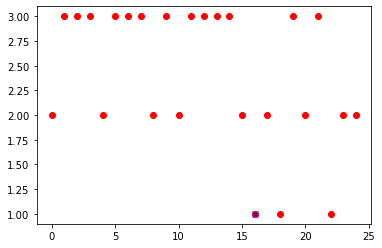

Finalized Weights: [-0.48014163  0.81632456  0.66691836]

x1,y1: [-1, 1.9439653521384954]  | x2,y2  [1, -0.5040840707174563]


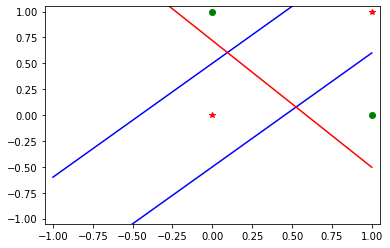

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy


# Method which uses the random library to return a weight value between -1 and 1.
def initialize_weights():
    # Initialize Weights
    w = []

    for i in range(3):
        w.append(random.random()*2 - 1)
        
    return w

# The visualize guess method simply plots the data points, the target line and the guess line.
def visualize_guess(w,finished):

    #Data to Classify
    if finished:
        color = "r"
    else:
        color = (random.random(), random.random(), random.random())
    plt.axis([-1.05, 1.05, -1.05, 1.05])
    plt.plot(0, 0, 'r*')
    plt.plot(1, 0, 'go')
    plt.plot(0, 1, 'go')
    plt.plot(1, 1, 'r*')

    # Target Decision Line
    # w0 < 0
    # w1 >= -w0
    # w2 >= -w0
    # w1 + w2 < -w0
    # Impossible for one perceptron
    
    px1 = -1
    m = 1.1/1 # -w1/w2
    b = -.5/1 # -w0/w2
    py1 = m*px1 + b
    px2 = 1
    py2 = m*px2 + b

    plt.plot([px1, px2], [py1, py2], 'b')

    px1 = -1
    m = 1.1/1 # -w1/w2
    b = 0.5/1 # -w0/w2
    py1 = m*px1 + b
    px2 = 1
    py2 = m*px2 + b

    plt.plot([px1, px2], [py1, py2], 'b')


    # Guess
    m = -w[1]/w[2]
    b = -w[0]/w[2]
    py1 = m*px1 + b
    px2 = 1
    py2 = m*px2 + b

    plt.plot([px1, px2], [py1, py2], color)
    if finished:
        print("x1,y1: {}  | x2,y2  {}".format([px1, py1], [px2, py2]))
    

# The truth table method requires manual input of the x values. It is simply here to display the truth table to the user.
def truth_table(y):

    #Truth Table

    x0 = np.array([(1, 1, 1, 1)])
    x1 = np.array([(1, 1, 0, 0)])
    x2 = np.array([(1, 0, 1, 0)])
    y = np.array([(y)])
    truth = np.concatenate((x1.T, x2.T, y.T), axis = 1)
    print("Truth Table for XOR:\n {}\n".format(truth))
    return [x0, x1, x2]

def tan_act(w, x):
    #e^x/e^x +1
    # Where x = W.T*x
    g = np.array([])
    #print(np.array([w]))
    wtX = np.inner(np.array(w), x)
    #print("Wtx:\n {}".format(wtX))
    
    for i in range(len(wtX)):
        g = np.append(g, np.tanh(wtX[i]))
        #print("test: {}".format(g))
    return g
   

# The activation method returns the activation array of the input weights.
def activation_function(w, x0, x1, x2):
    # Weight Check to Truth Table

    x = np.concatenate((x0.T, x1.T, x2.T),axis = 1)
    g = tan_act(w, x)
    return [x, g]


# The alter weights method decreases or increases the weights by the learning array dependent on which points were activated or not.
def alter_weights(learning_rate,w,x, index, sign):

    # Multiply the x inputs by the learning rate to generate a learning array.
    learning_array = np.multiply(x,learning_rate)
    
    # If the sign of the incorrect activation element is supposed to be positive: increase, if it is supposed to be negative: decrease.
    if sign >= 0:
        w = np.add(np.array(w),learning_array[index])
    elif sign < 0:
        w = np.subtract(np.array(w),learning_array[index])
    return w
    
# Method which takes the "logic array", an array telling if an element is on or off based on its sign, and compares the current with the guess
# The method returns the index of an incorrect node and the sign it is supposed to be.
def find_mismatch(y, logic_array_target, logic_array_guess,random_guess):
    temporary_array = list(range(len(logic_array_guess)))
    
    for i in range(len(logic_array_guess)):

        if random_guess == True:
            selected_index = random.choice(temporary_array)
        else:
            selected_index = i

        if logic_array_guess[selected_index] != logic_array_target[selected_index]:
            
            return [selected_index, logic_array_target[selected_index]]
        
        if len(temporary_array) > 0:
            temporary_array.remove(selected_index)
        

# Function returning the weights with a smaller error
def error_check(w, g, test_w, test_g, logic_array_guess, logic_array_target, lr):
    logic_array_test = list(map(lambda x: np.sign(x), test_g))
    error_original =[]
    error_test = []
    for i in range(len(logic_array_target)):
        error_original.append(logic_array_guess[i] != logic_array_target[i])
        error_test.append(logic_array_test[i] != logic_array_target[i])
    
    #print(sum(error_test)/len(error_test))
    #print(sum(error_original)/len(error_original))
    if sum(error_test)/len(error_test) < sum(error_original)/len(error_original):
        lr -= 0.01
        if lr<=0:
            lr = 0.1        
        return [test_w, test_g, False, lr, sum(error_test), sum(error_test)]
    else:
        lr += 0.01 
        if lr>1:
            lr = 0.1
        return [w, g, True, lr, None, sum(error_test)]
        
        
# This is a reduced version of the pocket algorithm. It continuously cycles the weight values producing increasingly accurate...
# values until it is able to correctly separate the nodes. It does not take into account the amount of error. 
def pocket_algorithm(w, g, logic_array_target, learning_rate, x, x_list, y):
    count = 0
    error_array = []
    er_pk_ar = []
    pocket_w = w
    test_w = w
    test_g = g
    random_guess = False
    count_error = 1
    logic_array_guess = None
    while logic_array_guess != logic_array_target:
        
        count += 1
        logic_array_guess = []
        logic_array_guess = list(map(lambda x: np.sign(x), test_g))
        logic_array_pocket = list(map(lambda x: np.sign(x), g))
        if (logic_array_guess == logic_array_target):
            break
        
        temp = find_mismatch(y, logic_array_target, logic_array_guess, random_guess)
            
        if temp == None:
            continue
                
        truth_table_index = temp[0]
        sign = temp[1]
        test_w = alter_weights(learning_rate, test_w, x, truth_table_index, sign)
        test_g = activation_function(test_w, x_list[0], x_list[1], x_list[2])[1]
        [pocket_w, g, random_guess, learning_rate, error_temp, error_current] = error_check(pocket_w, g, test_w, test_g, logic_array_pocket, logic_array_target, learning_rate)
        if error_temp != None:
            error_pocket = error_temp
            er_pk_ar.append(error_temp)      
        
        else:
            er_pk_ar.append(None)
        error_array.append(error_current)
        if count >= 25:
            print("Took too long.\n")
            test_g = g
            test_w = pocket_w
            break
    g = test_g
    pocket_w = test_w    
    print("Learning Rate: {}".format(learning_rate))    
    print("Iterations: {}\n".format(count))   
    print("New Activation Array: {}\n".format(g))
    print("Pocket Error: {}\nPLA Error w/out Pocket: {}\n".format(error_pocket,error_current))
    plt.figure(1)
    plt.plot(list(range(count)),error_array,'ro')
    plt.plot(list(range(count)),er_pk_ar,'bx')
    plt.show()
    plt.figure(0)
    return pocket_w






# Execution Code Begins Here

## This sets up our variables, prints our initial weights, runs the pocket algorithm, then prints the final weights and displays the chart.
learning_rate = 0.01
logic_array_target = [-1, 1, 1, -1]
output = [0, 1, 1, 0]
w = initialize_weights()
#w = [1, -1, 0]
print("Weights: {}\n".format(w))
plt.figure(0)
x_list = truth_table(output)
[x, g] = activation_function(w, x_list[0], x_list[1], x_list[2])
w = pocket_algorithm(w, g, logic_array_target, learning_rate, x, x_list, output)

print("Finalized Weights: {}\n".format(w))

visualize_guess(w,True)
plt.show()